In [53]:
import os
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mne.time_frequency import psd_array_multitaper

from shared.helper_functions import save_figure
from resting_state.settings import *

In [2]:
epoch_folder = paths_resting_state['epochs_folder']
plot_folder = paths_resting_state['plots_folder']

### Try out on test subject (normalized and absolute PSDs)
Load the epochs of a test subject

In [3]:
subject_id = 39508
epochs = mne.read_epochs(os.path.join(epoch_folder, f"epochs_w_cluster_annotations_{subject_id}-epo.fif"), preload=True)

Reading C:\Users\Olle de Jong\Documents\MSc Biology\rp2\rp2_data\resting_state\output\epochs\epochs_w_cluster_annotations_39508-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    4998.53 ms
        0 CTF compensation matrices available
Adding metadata with 6 columns
389 matching events found
No baseline correction applied
0 projection items activated


Get the cluster annotations for this subject

In [4]:
annotations = cluster_annotations[subject_id]
annotations

{'rest': 1, 'sleep': 0, 'active': 2}

In [5]:
np.unique(epochs.metadata.cluster, return_counts=True)[1]

array([211,  26, 152], dtype=int64)

Split the data

In [6]:
resting_epochs = epochs[epochs.metadata["cluster"] == annotations['rest']]
sleep_epochs = epochs[epochs.metadata["cluster"] == annotations['sleep']]
active_epochs = epochs[epochs.metadata["cluster"] == annotations['active']]

Get the channels we want to analyze

In [7]:
wanted_chans = [channel for channel in epochs.info["ch_names"] if not channel in ['EMG_L', 'EMG_R']]
wanted_chans

['OFC_R', 'OFC_L', 'CG', 'STR_R', 'S1_L', 'S1_R', 'V1_R']

In [9]:
behavioral_dfs = {}
for behaviour, epochs in {'resting': resting_epochs, 'sleeping': sleep_epochs, 'active': active_epochs}.items():
    print(f"Generating {behaviour} dataframe.")
    # loop through channels, as we want data per channel
    
    df = pd.DataFrame()

    for channel in wanted_chans:
        for subject_id in epochs.metadata["animal_id"].unique():
            
            subject_data = epochs[epochs.metadata["animal_id"] == subject_id]
            subject_data = subject_data[:-1]  # somehow the last epoch has only 0.0 values, so we remove this
            genotype = subject_data.metadata["genotype"].iloc[0]

            # skip plotting data of bad quality
            if subject_id in low_qual_chans.keys():
                if channel in low_qual_chans[subject_id]: 
                    print(f"Omitting channel {channel} for subject {subject_id}.")
                    continue
            
            # get the average PSD for this subject
            psds_sub, freqs = psd_array_multitaper(
                subject_data.get_data(picks=channel),
                fmin=0, fmax=100,
                sfreq=subject_data.info['sfreq'],
                n_jobs=-1,
                verbose='WARNING'
            )
            total_power = np.sum(psds_sub, axis=-1)
            psds_sub_norm = psds_sub / total_power[:, np.newaxis]
            
            mean_psd_sub = np.mean(psds_sub[:, 0, :], axis=0)
            mean_psd_sub_norm = np.mean(psds_sub_norm[:, 0, :], axis=0)
            
            # save the average of this subject, so we can later plot the mean of the subject averages
            df = pd.concat([df, pd.DataFrame({
                "freq": freqs,
                "psd (means)": mean_psd_sub,
                "psd (norm)": mean_psd_sub_norm,
                "subject_id": subject_id,
                "genotype": genotype,
                "channel": channel,
            })])
                
    behavioral_dfs[behaviour] = df

Generating resting dataframe.
Generating sleeping dataframe.
Generating active dataframe.


In [10]:
behavioral_dfs["resting"]["behaviour"] = "Resting"
behavioral_dfs["sleeping"]["behaviour"] = "Sleeping"
behavioral_dfs["active"]["behaviour"] = "Active"
total_df = pd.concat([behavioral_dfs["resting"], behavioral_dfs["sleeping"], behavioral_dfs['active']])

Let's plot the Average PSD for each channel. We plot the absolute ones as we're only looking at one animal.

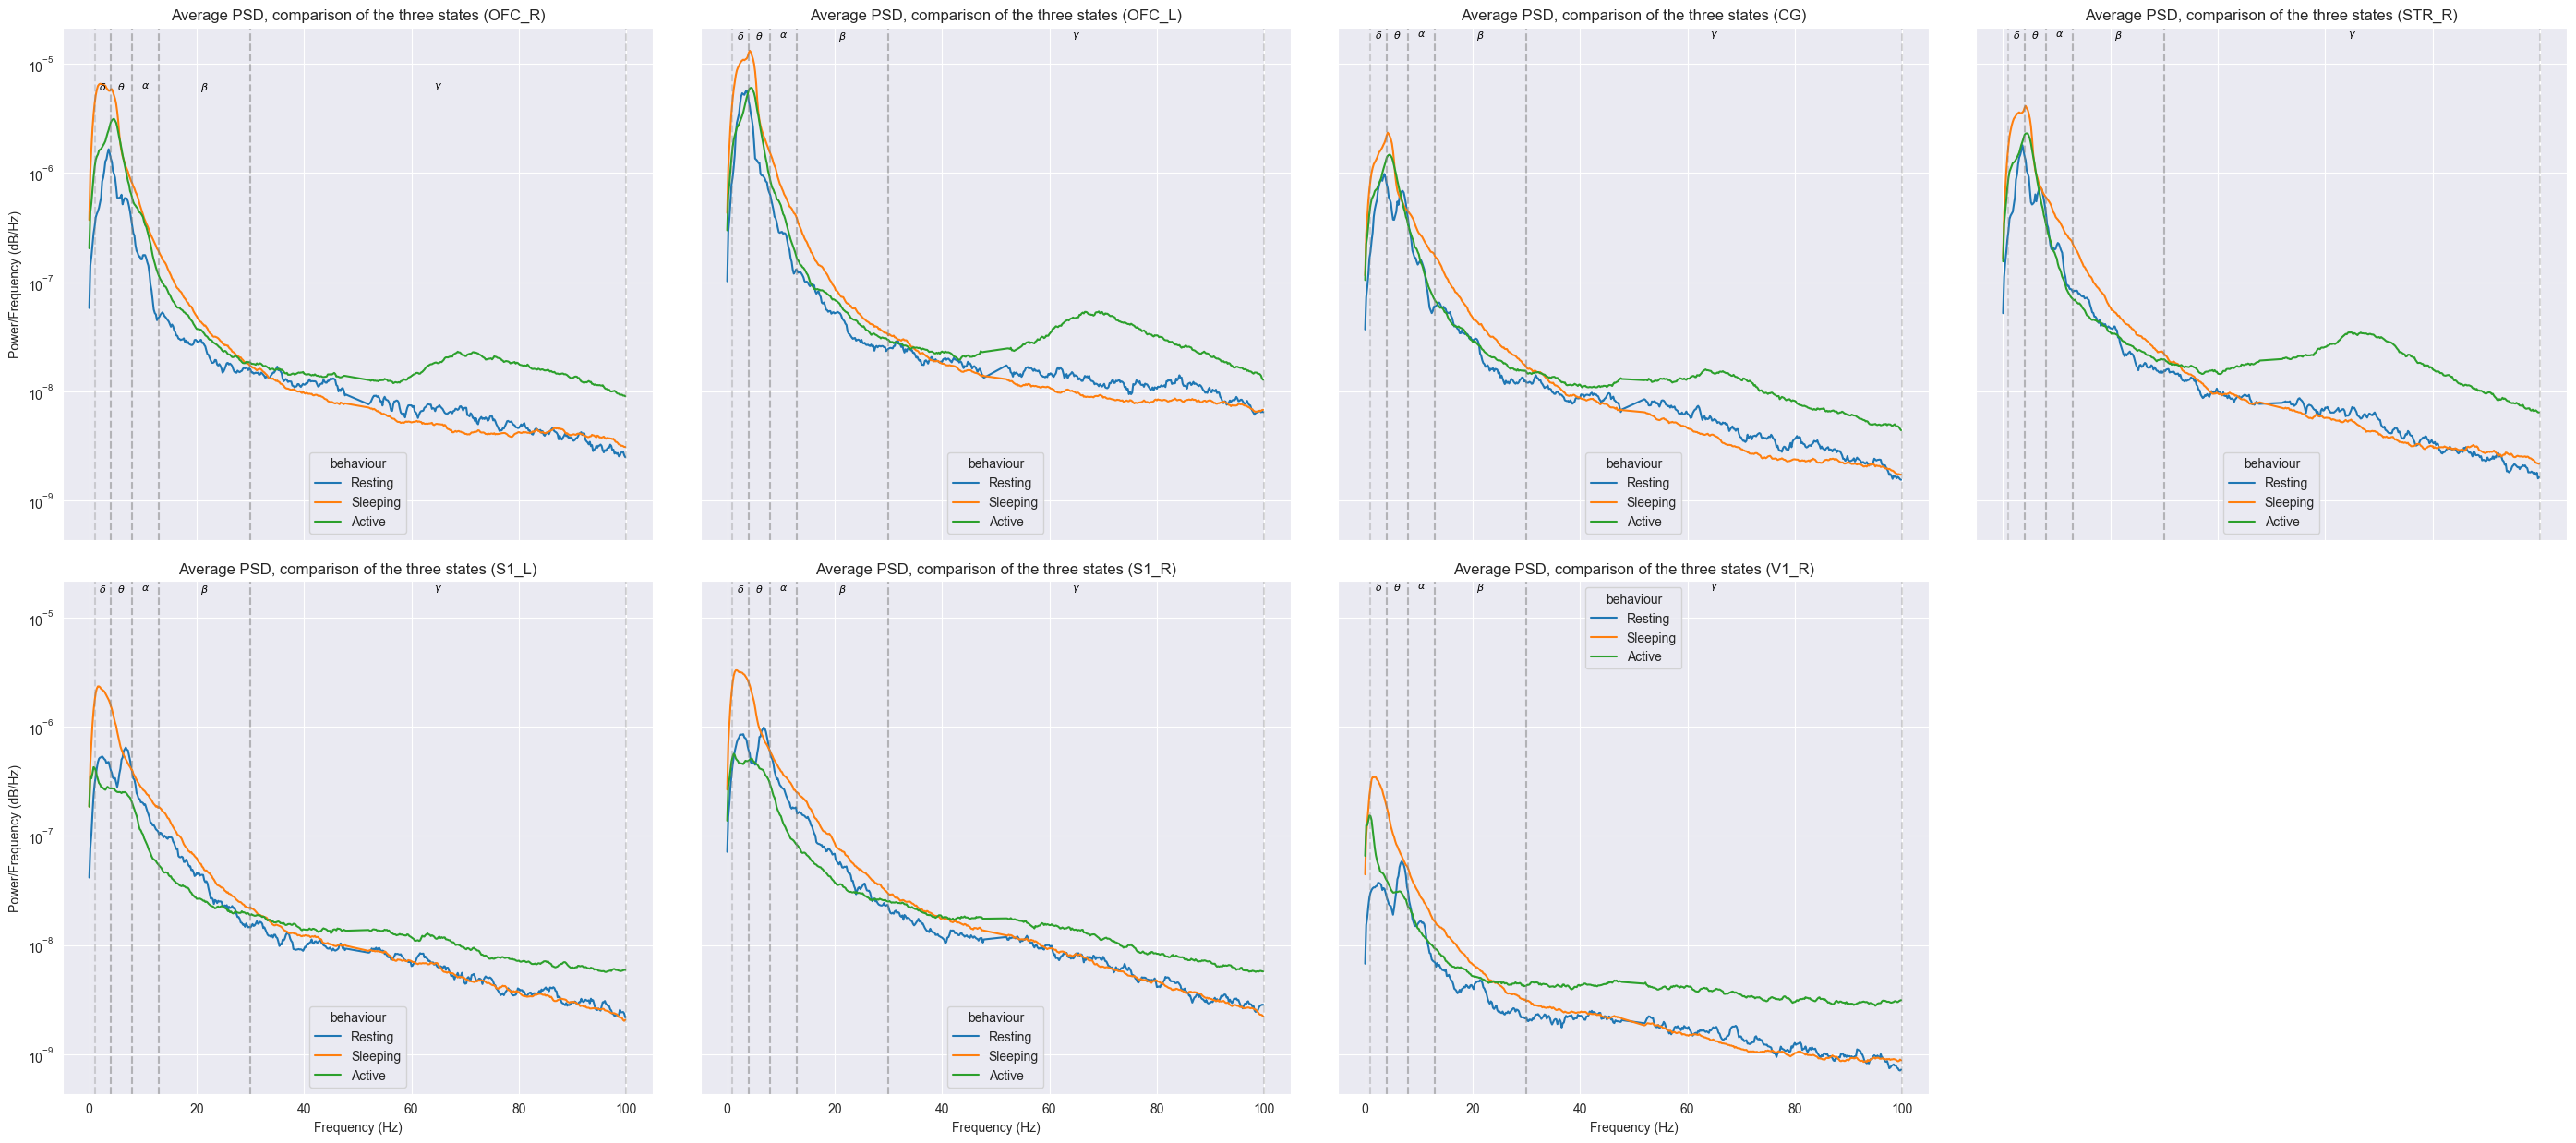

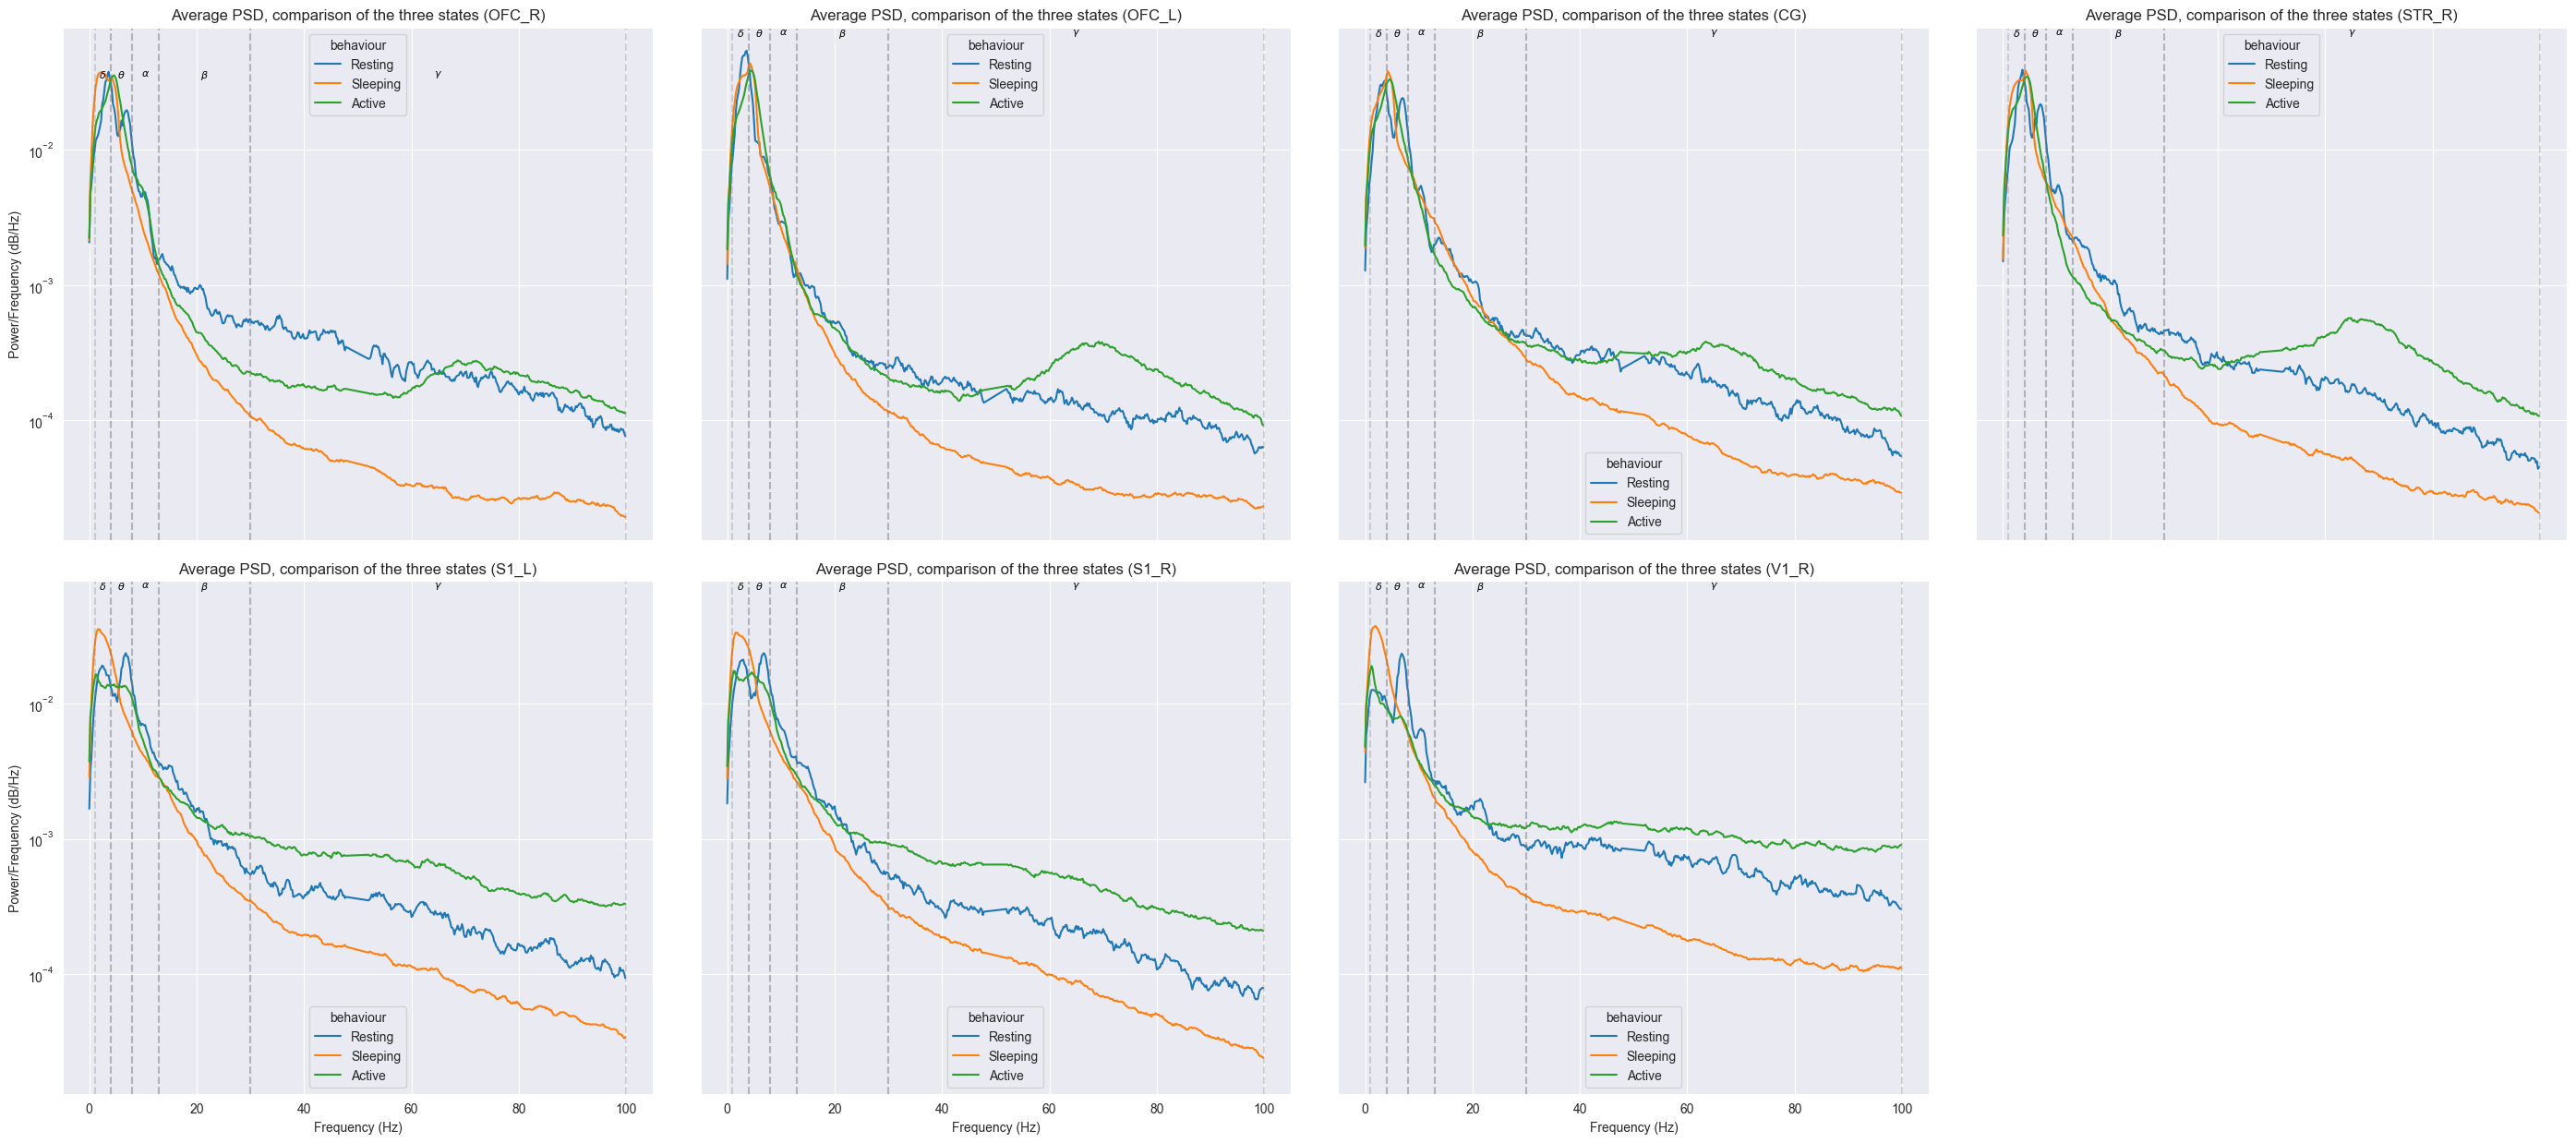

In [11]:
for y_axis in ['psd (means)', 'psd (norm)']:
    fig, axs = plt.subplots(2, 4, figsize=(35, 15), sharex=True, sharey=True)
    axs = axs.ravel()
    
    for i, channel in enumerate(wanted_chans):
        
        channel_data = total_df[total_df.channel == channel]
        channel_data = channel_data[(channel_data.freq > 52) | (channel_data.freq < 48)]  # remove the 50Hz peak
        
        sns.lineplot(data=channel_data, x='freq', y=y_axis, hue="behaviour", legend=True, ax=axs[i], errorbar='se')
        
        for band, (start, end) in freq_bands_eeg.items():
            axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
            axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
            axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
        
        axs[i].set_yscale('log')
        axs[i].set_xlabel('Frequency (Hz)')
        axs[i].set_ylabel('Power/Frequency (dB/Hz)')
        axs[i].set_title(f'Average PSD, comparison of the three states ({channel})')
    
    plt.subplots_adjust(wspace=0.08, hspace=0.08)
    axs[-1].remove()
    plt.show()

## Perform same on all resting-state epochs ( WT vs KO )

First, we load all epochs of the subjects that are not omitted

In [13]:
all_subject_epochs = []
for file in os.listdir(epoch_folder):
    subj_id = file.split('_')[-1].split('-')[0]
    if not file.startswith('epochs_w_cluster_annotations') or int(subj_id) in omitted_after_clustering:
        continue
    all_subject_epochs.append(mne.read_epochs(os.path.join(epoch_folder, file), preload=True, verbose='WARNING'))

Then we generate a df holding PSD data on all the epochs so we can later plot the PSDs of the DRD2-WTs versus the DRD2-KOs

In [56]:
df = pd.DataFrame()

for i, channel in enumerate(wanted_chans):
    print(f'Getting PSDs for channel {channel}')
    for subject_epochs in all_subject_epochs:
        # slice resting epoch cluster from all non-movement epochs
        subject_id = int(subject_epochs.metadata["animal_id"].iloc[0])
        resting_epochs = subject_epochs[subject_epochs.metadata["cluster"] == cluster_annotations[subject_id]['rest']]
        genotype = resting_epochs.metadata["genotype"].iloc[0]

        # skip plotting data of bad quality
        if subject_id in low_qual_chans.keys():
            if channel in low_qual_chans[subject_id]: 
                print(f"Omitting channel {channel} for subject {subject_id}.")
                continue

        # get the average PSD for this subject
        psds_sub, freqs = psd_array_multitaper(
            resting_epochs.get_data(picks=channel),
            fmin=0, fmax=100,
            sfreq=resting_epochs.info['sfreq'],
            n_jobs=-1,
            normalization='full',
            verbose='WARNING'
        )
        total_power = np.sum(psds_sub, axis=-1)
        psds_sub_norm = psds_sub / total_power[:, np.newaxis]
        
        mean_psd_sub = np.mean(psds_sub[:, 0, :], axis=0)
        mean_psd_sub_norm = np.mean(psds_sub_norm[:, 0, :], axis=0)

        # save the average of this subject, so we can later plot the mean of the subject averages
        df = pd.concat([df, pd.DataFrame({
            "freq": freqs,
            "psd (means)": mean_psd_sub,
            "psd (norm)": mean_psd_sub_norm,
            "subject_id": subject_id,
            "genotype": genotype,
            "channel": channel,
        })])
        
    print(f"Done with channel {channel}.")

Getting PSDs for channel OFC_R
Omitting channel OFC_R for subject 39489.
Omitting channel OFC_R for subject 81193.
Done with channel OFC_R.
Getting PSDs for channel OFC_L
Omitting channel OFC_L for subject 80625.
Omitting channel OFC_L for subject 81193.
Done with channel OFC_L.
Getting PSDs for channel CG
Done with channel CG.
Getting PSDs for channel STR_R
Done with channel STR_R.
Getting PSDs for channel S1_L
Done with channel S1_L.
Getting PSDs for channel S1_R
Done with channel S1_R.
Getting PSDs for channel V1_R
Done with channel V1_R.


Let's plot the average absolute and normalized PSDs per channel

In [57]:
for y_axis in ['psd (means)', 'psd (norm)']:
    fig, axs = plt.subplots(2, 4, figsize=(35, 15), sharex=True, sharey=True)
    axs = axs.ravel()
    
    subjects = df["subject_id"].unique()
    for i, channel in enumerate(wanted_chans):
    
        channel_data = df[df.channel == channel]
        channel_data = channel_data[(channel_data.freq > 51) | (channel_data.freq < 49)]  # remove the 50Hz peak
        
        palette = {'DRD2-WT': '#427C99', 'DRD2-KO': '#AF5541'}
        sns.lineplot(data=channel_data, x='freq', y=y_axis, palette=palette, hue_order=['DRD2-WT', 'DRD2-KO'], hue='genotype', legend=True, ax=axs[i], errorbar=('ci', 95))
        
        for band, (start, end) in freq_bands_eeg.items():
            axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.40)
            axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.40)
            axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
        
        axs[i].set_yscale('log')
        axs[i].set_xlabel('Frequency (Hz)')
        axs[i].set_ylabel('Power/Frequency (dB/Hz)')
        axs[i].set_title(f'Average PSD per genotype ({channel})')
    
    plt.subplots_adjust(wspace=0.08, hspace=0.08)
    axs[-1].remove()
    save_figure(os.path.join(plot_folder, 'resting_state', f"WT_vs_KO_{'norm' if 'norm' in y_axis else 'abs'}_PSD_averages.pdf"))

Now with the individual traces as well

In [58]:
for y_axis in ['psd (means)', 'psd (norm)']:
    fig, axs = plt.subplots(2, 4, figsize=(35, 15), sharex=True, sharey=True)
    axs = axs.ravel()
    
    subjects = df["subject_id"].unique()
    palettes = {}
    for subject in subjects:
        if df[df["subject_id"] == subject].genotype.iloc[0] == "DRD2-WT":
            palettes[subject] = '#427C99'
        else:
            palettes[subject] = '#AF5541'
    
    for i, channel in enumerate(wanted_chans):
    
        channel_data = df[df.channel == channel]
        channel_data = channel_data[(channel_data.freq > 51) | (channel_data.freq < 49)]  # remove the 50Hz peak
        
        palette = {'DRD2-WT': '#427C99', 'DRD2-KO': '#AF5541'}
        sns.lineplot(data=channel_data, x='freq', y=y_axis, palette=palette, hue_order=['DRD2-WT', 'DRD2-KO'], hue='genotype', legend=True, ax=axs[i], errorbar=('ci', 95))
        sns.lineplot(data=channel_data, x='freq', y=y_axis, palette=palettes, hue='subject_id', linewidth=.3, legend=False, ax=axs[i], alpha=.35)
        
        for band, (start, end) in freq_bands_eeg.items():
            axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.4)
            axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.4)
            axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
        
        axs[i].set_yscale('log')
        axs[i].set_xlabel('Frequency (Hz)')
        axs[i].set_ylabel('Power/Frequency (dB/Hz)')
        axs[i].set_title(f'Average PSD per genotype (with subject averages) ({channel})')
    
    plt.subplots_adjust(wspace=0.08, hspace=0.08)
    axs[-1].remove()
    save_figure(os.path.join(plot_folder, 'resting_state', f"WT_vs_KO_{'norm' if 'norm' in y_axis else 'abs'}_PSD_averages_w_subjects.pdf"))